In [1]:
#x01_populationStatistics

In [12]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### BREEDING SIMULATOR
class Genome:
    def __init__(self, n_chr, n_loci, seed=None):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        if seed is not None:
            set_seed(seed)

class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.bvs = None
        self.haplotypes = haplotypes.to(device)
        self.dosages = haplotypes.sum(dim=1).float().to(device)
        self.size = haplotypes.shape[0]

class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device, seed=None):
        if seed is not None:
            set_seed(seed)
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)

        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages).to(device)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean


def calculate_breeding_value(population, trait, device=device):
    return torch.einsum('hjk,jk->h', population.dosages, trait.effects).to(device)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices.to(device)

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:], parent_haplo_tensor[:,1,:,:]
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny



def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices.to(device)

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:], parent_haplo_tensor[:,1,:,:]
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny

def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population, trait)
    population.breeding_values = breeding_values
    if breeding_values.var() == 0:
        environmental_variance = 0
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var()

    # Check if environmental_variance is zero before applying torch.sqrt and .clone()
    if environmental_variance == 0:
        environmental_noise = torch.zeros(breeding_values.shape, device=device)
    else:
        environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance).detach()

    population.breeding_values = breeding_values
    population.phenotypes = breeding_values + environmental_noise

    return population.phenotypes.max()

def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device=device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)

def create_progeny(mother_gametes, father_gametes, reps=1, device=device):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0], device=device)
        shuffled_father_indices = torch.randperm(father_gametes.shape[0], device=device)

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes), dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)


def random_crosses(parent_population, total_crosses, device=device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    num_parents = parent_population.shape[0]
    ploidy, num_chromosomes, num_loci = parent_population.shape[1:]
    
    # Randomly select parents for each cross
    parent_indices = torch.randint(0, num_parents, (total_crosses, 2), device=device)
    
    # Select the parent haplotypes
    mothers = parent_population[parent_indices[:, 0]]
    fathers = parent_population[parent_indices[:, 1]]
    
    # Perform recombination for both parents
    mother_gametes = recombine(mothers)
    father_gametes = recombine(fathers)
    
    # Combine gametes to create progeny
    progeny = torch.stack((mother_gametes, father_gametes), dim=1)
    
    return progeny

def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population, trait)
    population.breeding_values = breeding_values
    population.genetic_var = breeding_values.var()
    if breeding_values.var() == 0:
        environmental_variance = 0
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var()

    # Check if environmental_variance is zero before applying torch.sqrt and .clone()
    if environmental_variance == 0:
        environmental_noise = torch.zeros(breeding_values.shape, device=device)
    else:
        environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance).detach()
    population.phenotypes = breeding_values + environmental_noise

class SimParams:
    def __init__(self, G, T, h2, reps, pop_size, max_generations, founder_pop, seed=None):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.founder_pop = founder_pop
        self.seed = seed
        if seed is not None:
            set_seed(seed)

def scale_values(x, from_range=(-1, 1), to_range=(0.05, 0.95)):
    # Ensure input is a PyTorch tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    
    # Unpack the ranges
    from_min, from_max = from_range
    to_min, to_max = to_range
    
    # Scale the values
    scaled = (x - from_min) / (from_max - from_min) * (to_max - to_min) + to_min
    
    return scaled

0.5225

In [3]:
import torch as th
import torch.nn as nn
from gymnasium import spaces
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from typing import Tuple, Callable
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict):
        super().__init__(observation_space, features_dim=64)
        
        pop_shape = observation_space.spaces["population"].shape
        self.pop_extractor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(pop_shape[0] * pop_shape[1] * pop_shape[2] * pop_shape[3], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.gen_extractor = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU()
        )
        
        self.combined = nn.Sequential(
            nn.Linear(80, 64),
            nn.ReLU()
        )

    def forward(self, observations) -> th.Tensor:
        pop_features = self.pop_extractor(observations["population"])
        gen_features = self.gen_extractor(observations["generation"])
        combined = th.cat([pop_features, gen_features], dim=1)
        return self.combined(combined)

class CustomNetwork(nn.Module):
    def __init__(self, feature_dim: int, last_layer_dim_pi: int = 64, last_layer_dim_vf: int = 64):
        super().__init__()
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf
        
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi),
            nn.ReLU()
        )
        
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf),
            nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)

class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):
        kwargs["features_extractor_class"] = CustomFeatureExtractor
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            *args,
            **kwargs,
        )

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [17]:

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter

class ActionTrackingCallback(BaseCallback):
    def __init__(self, log_freq=100, verbose=0):
        super(ActionTrackingCallback, self).__init__(verbose)
        self.log_freq = log_freq
        self.episode_count = 0
        self.action_history = defaultdict(list)
        self.current_episode_actions = []
        self.max_generations = None
        self.step_count = 0
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        self.step_count += 1
        info = self.locals['infos'][0]
        action = self.locals['actions'][0]
        current_generation = info['current_generation']
        
        if self.max_generations is None:
            self.max_generations = self.training_env.get_attr('max_generations')[0]

        # Normalize action from [-1, 1] to [0, 1]
#         normalized_action = (action.item() + 1) / 2
    # Use the normalized action from the environment
        normalized_action = info['normalized_action']

        self.current_episode_actions.append((current_generation, normalized_action))

        if self.locals['dones'][0]:
            self.episode_count += 1
            for gen, action in self.current_episode_actions:
                self.action_history[gen].append(action)
            self.current_episode_actions = []

            if self.episode_count % self.log_freq == 0:
                self._log_action_data()

        return True

    def _log_action_data(self):
        action_data = {}
        for gen in range(self.max_generations):
            if gen in self.action_history:
                avg_action = np.mean(self.action_history[gen])
                action_data[f"generation_{gen}"] = avg_action

        # Log all generation data at once
        self.writer.add_scalars("average_actions", action_data, self.step_count)

        # Clear the action history after logging
        self.action_history.clear()

    def on_training_end(self):
        # Final logging of action data
        self._log_action_data()
        if self.writer:
            self.writer.close()
            
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from collections import defaultdict
class AverageFinalGenerationCallback(BaseCallback):
    def __init__(self, log_freq=100, verbose=0):
        super(AverageFinalGenerationCallback, self).__init__(verbose)
        self.log_freq = log_freq
        self.phenotypes = []
        self.genetic_variances = []
        self.episode_count = 0
        self.all_action_values = []  # Store all action values
        self.current_episode_actions = []

    def _on_step(self) -> bool:
        action = self.locals['actions'][0]
        self.current_episode_actions.append(action.item())
        
        for env_idx, done in enumerate(self.locals['dones']):
            if done:
                info = self.locals['infos'][env_idx]
                if 'final_generation' in info:
                    self.episode_count += 1
                    final_gen_info = info['final_generation']
                    
                    phenotype = final_gen_info['max_phenotype']
                    if isinstance(phenotype, torch.Tensor):
                        phenotype = phenotype.cpu().numpy()
                    self.phenotypes.append(phenotype)
                    
                    genetic_variance = final_gen_info['genetic_variance']
                    if isinstance(genetic_variance, torch.Tensor):
                        genetic_variance = genetic_variance.cpu().numpy()
                    self.genetic_variances.append(genetic_variance)
                    
                    # Store actions for this episode
                    self.all_action_values.extend(self.current_episode_actions)
                    self.current_episode_actions = []  # Reset for next episode

                    # Log every log_freq episodes
                    if self.episode_count % self.log_freq == 0:
                        self._log_data()

        return True

    def _log_data(self):
        avg_phenotype = np.mean(self.phenotypes)
        avg_genetic_variance = np.mean(self.genetic_variances)
        self.logger.record("final_generation/max_phenotype", avg_phenotype)
        self.logger.record("final_generation/genetic_variance", avg_genetic_variance)
        
        # Plot action values
        self._plot_action_values()
        
        # Reset lists for next logging period
        self.phenotypes = []
        self.genetic_variances = []
        self.all_action_values = []  # Store all action values

    def _plot_action_values(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.all_action_values)
        plt.title("Action Values Across All Training Steps")
        plt.xlabel("Training Step")
        plt.ylabel("Action Value")
        plt.ylim(0, 1)  # Assuming action values are between 0 and 1
        plt.savefig(f"action_values_plot_{self.episode_count}.png")
        plt.close()

    def on_training_end(self):
        # Plot final action values chart
        self._plot_action_values()
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from collections import defaultdict


In [18]:
class DynamicMaxGenerationsCallback(BaseCallback):
    def __init__(self, max_generations, total_timesteps, verbose=0):
        super(DynamicMaxGenerationsCallback, self).__init__(verbose)
        self.max_generations = max_generations
        self.total_timesteps = total_timesteps
        self.current_max_gen = 1

    def _on_step(self) -> bool:
        progress = self.num_timesteps / self.total_timesteps
        new_max_gen = int(np.ceil(progress * self.max_generations))
        
        if new_max_gen > self.current_max_gen:
            self.current_max_gen = new_max_gen
            self.training_env.env_method("update_max_generations", self.current_max_gen)
            if self.verbose > 0:
                print(f"Updated max generations to {self.current_max_gen}")
        
        return True

In [24]:

# Assuming `SelectionIntensityEnvironment` is defined as per your provided context
class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config  # Store the config
        self.current_generation = 0
        self.max_generations = SP.max_generations
        # Get action space bounds from config, with defaults if not provided
        
        self.action_low = config.get('action_low', 0.01)
        self.action_high = config.get('action_high', 0.95)
        
        # Update action space with custom bounds
        self.action_space = gym.spaces.Box(
            low=np.array([-1]), 
            high=np.array([1]), 
            dtype=np.float32
        )
        
        self.observation_space = gym.spaces.Dict({
            "population": gym.spaces.Box(low=0, high=1, shape=(self.SP.pop_size, 2, self.SP.G.n_chr, self.SP.G.n_loci), dtype=np.int32),
            "generation": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        })
        # logging
        self.action_values = []
        self.genetic_variance = []
        self.max_breeding_values = []
        self.final_generations = []
        self.episode_count = 0
        self.rewards = []
        self.episode_reward = 0
        
        #config
        self.config =config
        
    def update_max_generations(self, new_max_gen):
        self.max_generations = new_max_gen
        self.SP.max_generations = new_max_gen
        # Update observation space if necessary
        self.observation_space = gym.spaces.Dict({
            "population": gym.spaces.Box(low=0, high=1, shape=(self.SP.pop_size, 2, self.SP.G.n_chr, self.SP.G.n_loci), dtype=np.int32),
            "generation": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        })
        
    def _get_obs(self):
        population = self.population.haplotypes.cpu().numpy().astype(np.int32)
        generation = np.array([self.current_generation / self.SP.max_generations], dtype=np.float32)
        return {"population": population, "generation": generation}

    def _get_info(self):
        return {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.population = self.SP.founder_pop
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation = 0
        self.episode_reward = 0
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        
        print(action)
        # Map the action from [-1, 1] to [action_low, action_high]
        action = map_value(action, self.action_low, self.action_high)
        print(action)

        # Ensure action_scalar is within bounds
#         action_scalar = np.clip(action_scalar, self.action_low, self.action_high)
        selected = torch.topk(self.population.phenotypes, int(action * self.population.size)).indices
        self.population = create_pop(self.SP.G, random_crosses(self.population.haplotypes[selected], self.SP.pop_size))
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation += 1

        observation = self._get_obs()
        info = self._get_info()
        info['normalized_action'] = action


        
        terminated = self.current_generation >= self.SP.max_generations or self.population.genetic_var < .005
        #REWARD
        if self.config.get('sparse_reward', False):  # Use .get() with a default value
            reward = 0 if not terminated else float(self.population.breeding_values.max())
        else:
            reward = float(self.population.breeding_values.max())
        self.episode_reward += reward

        if terminated:
            info['final_generation'] = {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
            }

        return observation, reward, bool(terminated), False, info



In [25]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv
import random


def create_random_pop(G, pop_size, seed=None):
    if seed is not None:
        set_seed(seed)
    return torch.randint(0, 2, (pop_size, *G.shape), device=device)

# Example usage
n_chr = 1
n_parents = 5
n_loci = 100
founder_pop_size = 100
h2 = 1
reps = 1
max_generations = 10
seed = 422  # Choose any integer for your seed
G = Genome(n_chr, n_loci, seed=seed)



#set up the initial population

founder_haplotypes = np.load('./data/g2f_ch10.npy') 
random_parent_indicies =  np.random.choice(founder_haplotypes.shape[0], n_parents, replace=False)
random_loci_indices = np.random.choice(founder_haplotypes.shape[2], n_loci, replace=False)
founder_haplotypes = founder_haplotypes[random_parent_indicies,:,:]
founder_haplotypes = founder_haplotypes[:,:,random_loci_indices]
founder_haplotypes = torch.tensor(founder_haplotypes)
founder_haplotypes = founder_haplotypes.unsqueeze(2) 


founder_pop = create_pop(G, founder_haplotypes)
founder_pop = random_crosses(founder_pop.haplotypes,founder_pop_size)
founder_pop = create_pop(G, founder_pop)



T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0, seed=seed)
SP = SimParams(G, T, h2, reps, founder_pop_size, max_generations, founder_pop, seed=seed)


# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=100)
action_callback = ActionTrackingCallback(log_freq=10)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])

# Create the environment
config = {'sparse_reward':True}
env = SelectionIntensityEnvironment(SP, config)
x = env.reset()

Summary Statistics:
Mean: 2.86
Median: 3.22
Standard Deviation: 0.99
Minimum: 0.39
Maximum: 4.11
Sum: 286.29


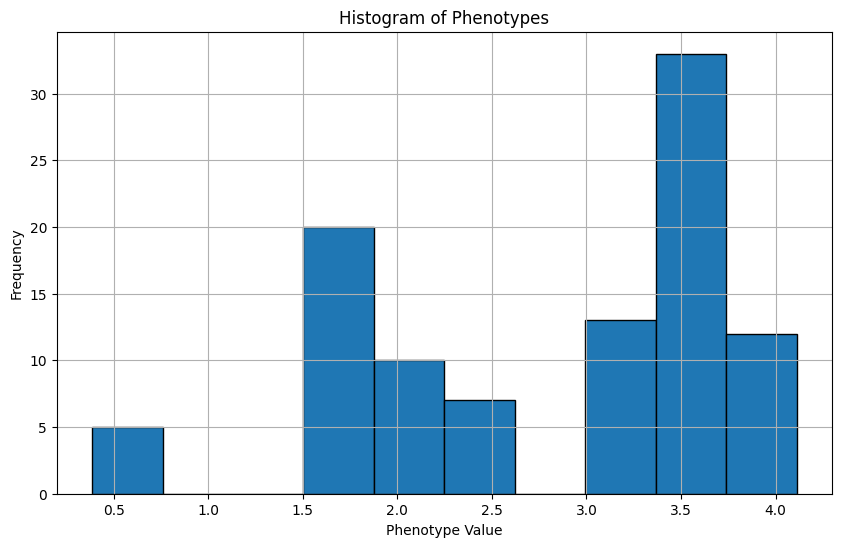

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Convert torch tensor to numpy array if necessary
phenotypes = env.population.breeding_values.numpy()

# Calculate summary statistics
mean_phenotype = np.mean(phenotypes)
median_phenotype = np.median(phenotypes)
std_phenotype = np.std(phenotypes)
min_phenotype = np.min(phenotypes)
max_phenotype = np.max(phenotypes)
sum_phenotype = np.sum(phenotypes)

# Print summary statistics
print("Summary Statistics:")
print(f"Mean: {mean_phenotype:.2f}")
print(f"Median: {median_phenotype:.2f}")
print(f"Standard Deviation: {std_phenotype:.2f}")
print(f"Minimum: {min_phenotype:.2f}")
print(f"Maximum: {max_phenotype:.2f}")
print(f"Sum: {sum_phenotype:.2f}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(phenotypes, bins=10, edgecolor='black')
plt.title('Histogram of Phenotypes')
plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

[0.05, 0.5, 0.9]
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.05
0.5035
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.5
0.715
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903
0.9
0.903


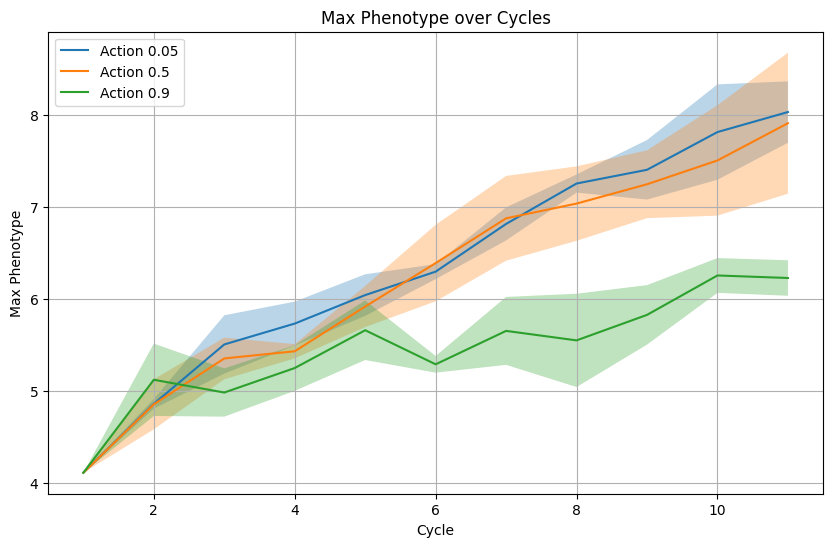

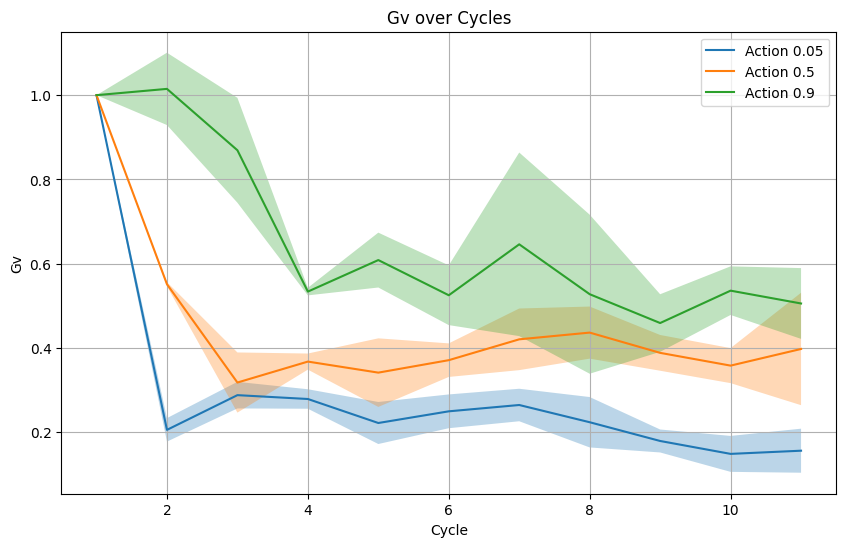

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming SimulatedEnv and Population classes are already defined as in your code

def collect_baselines(env, actions, repetitions=100, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    
    for action in actions:
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            max_phenotype = env.population.breeding_values.max()
            gv = env.population.breeding_values.var()
            cycle_max_phenotype.append(max_phenotype)
            cycle_gv.append(gv)
            for _ in range(cycles):
                env.step(np.array(action))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
    
    return results

def plot_results(results, metric):
    plt.figure(figsize=(10, 6))
    
    for action, data in results.items():
        mean_values = np.mean(data[metric], axis=0)
        std_values = np.std(data[metric], axis=0)
        cycles = range(1, len(mean_values) + 1)
        
        plt.plot(cycles, mean_values, label=f'Action {action}')
        plt.fill_between(cycles, mean_values - std_values, mean_values + std_values, alpha=0.3)
    
    plt.xlabel('Cycle')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} over Cycles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Set up the environment and actions
actions = [.05, .5, .9 ]
actions = [map_value(x, -1, 1) for x in actions]
print(actions)
# Collect baselines
results = collect_baselines(env, actions, repetitions=3,cycles=SP.max_generations)

# Plot results
plot_results(results, 'max_phenotype')
plot_results(results, 'gv')

In [9]:

# # Wrap the environment (required for SB3)
# env.reset()
# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=250000, callback=combined_callbacks)

In [10]:

# # Create the environment
# config = {}
# env = SelectionIntensityEnvironment(SP, config)

# # Wrap the environment (required for SB3)
# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=100000, callback=combined_callbacks)

In [11]:
SP.max_generations

10